In [2]:
!pip install coverage>=4.4.0 hypothesis>=4.24.3 fastjsonschema>=2.10 ipython ipykernel ipywidgets jsonschema>=2.6 jupyter matplotlib pillow>=4.2.1 black==21.4b2 pydot astroid==2.5 pylint==2.7.1 stestr>=2.0.0  PyGithub wheel cython>=0.27.1 pylatexenc>=1.4 ddt>=1.2.0,!=1.4.0 seaborn>=0.9.0 reno>=3.2.0 Sphinx>=3.0.0 qiskit numpy>=1.17 scipy>=1.4 qiskit-sphinx-theme>=1.6 sphinx-autodoc-typehints jupyter-sphinx sphinx-panels==0.6.0 pygments>=2.4 networkx>=2.2 scikit-learn>=0.20.0 qiskit_aer
!pip install qiskit qiskit-ibm-runtime -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of sphinx-panels to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.0/131.0 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.3/220.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.0/343.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.7/475.7 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.0/118.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.9/375.9 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import time

In [5]:
from qiskit import QuantumCircuit, transpile
import qiskit
import numpy as np
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import UnitaryGate
from IPython.display import display
import pylatexenc
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

## Setting up the Quantum Computer

In [11]:
# Using RPI Quantum Computer

# service = QiskitRuntimeService(channel="ibm_quantum", token="6a26e5e1fd93deacdb493ae028ecb7e2ee81a7fb4d925cd804996effe7cde3d0b241a1d0284dbfa6a8108b91975d0fe561de7f8e7269b3462289c30f96d4b302" )
# backend = service.backend(name = "ibm_rensselaer")

# using a simulated quantum Computer
backend = Aer.get_backend('qasm_simulator')

backend.num_qubits

29

In [12]:
from qiskit.primitives import Estimator
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli

# Define a quantum circuit and observable (Pauli operator)

Kitaev Quantum Phase Estimation

In [45]:

class KQPE:
    """
    Implements the Kitaev's phase estimation algorithm where a single circuit
    is used to estimate the phase of a unitary, but the measurements are
    exponential.

    Attributes:
        precision (int): The precision up to which the phase needs to be estimated.
                         Precision is estimated as 2^(-precision).
        unitary (np.ndarray or QuantumCircuit or UnitaryGate): The unitary matrix for
                which we want to find the phase, given its eigenvector.
        qubits (int): The number of qubits on which the unitary matrix acts.

    Methods:
        get_phase(QC, ancilla, clbits, backend, show): Generate the resultant phase associated with
                      the given Unitary and the given eigenvector.
        get_circuit(show, save_circ, circ_name): Generate a Kitaev phase estimation circuit which
                      can be attached to the parent quantum circuit containing the eigenvector of the unitary matrix.
    """

    def __init__(self, unitary, precision=10):
        """
        Args:
            precision (int): The precision up to which the phase is estimated.
                             Interpreted as 2^(-precision). For example, precision = 4
                             means the phase is going to be precise up to 2^(-4).
            unitary (np.ndarray or UnitaryGate or QuantumCircuit): The unitary for
                             which we want to determine the phase.

        Raises:
            TypeError: If precision or unitary are not of a valid type.
            ValueError: If precision is not valid.
        """
        # Validate precision
        if not isinstance(precision, int):
            raise TypeError("Precision needs to be an integer")
        elif precision <= 0:
            raise ValueError("Precision needs to be >= 0")

        self.precision = 1 / (2 ** precision)

        # Validate unitary
        if unitary is None:
            raise Exception("Unitary needs to be specified for the Kitaev QPE algorithm")
        elif not isinstance(unitary, np.ndarray) and not isinstance(unitary, QuantumCircuit) and not isinstance(unitary, UnitaryGate):
            raise TypeError("A numpy array, QuantumCircuit or UnitaryGate needs to be passed as the unitary matrix")

        self.unitary = unitary

        # Determine the number of qubits in the unitary
        if isinstance(unitary, np.ndarray):
            self.qubits = int(np.log2(unitary.shape[0]))
        else:
            self.qubits = int(unitary.num_qubits)

    def get_phase(self, QC, ancilla, clbits, backend, show=False):
        """Determine the final measured phase from the circuit with the specified precision.

        Args:
            QC (QuantumCircuit): The quantum circuit on which we have attached
                                 the Kitaev's estimation circuit. Must contain at least 2
                                 classical bits for correct running of the algorithm.
            ancilla (list-like): The ancilla qubits to be used in the Kitaev phase estimation.
            clbits (list-like): The classical bits in which the measurement results
                                of the given ancilla qubits are stored.
            backend (Backend): The backend on which the circuit is executed.
            show (bool): Boolean to specify whether the progress and the circuit
                         need to be shown.

        Raises:
            TypeError: If a QuantumCircuit is not provided.
            Exception: If the circuit has less than 2 classical bits or less than 3 qubits,
                       or if the ancilla or clbits are not unique.

        Returns:
            tuple: (phase_dec, phase_binary) A tuple representing the calculated phase in
                   decimal and binary up to the given precision.
        """
        # Validate the input circuit
        if not isinstance(QC, QuantumCircuit):
            raise TypeError("A QuantumCircuit must be provided for generating the phase")
        if len(QC.clbits) < 2:
            raise Exception("At least 2 classical bits needed for measurement")
        elif len(QC.qubits) < 3:
            raise Exception("Quantum Circuit needs to have at least 3 qubits")

        # Validate ancilla and classical bits
        if len(ancilla) != 2 or ancilla is None:
            raise Exception("Exactly two ancilla bits need to be specified")
        if len(clbits) != 2 or clbits is None:
            raise Exception("Exactly two classical bits need to be specified for measurement")
        if len(set(clbits)) != len(clbits) or len(set(ancilla)) != len(ancilla):
            raise Exception("Duplicate bits provided in lists")

        # Calculate the number of shots (at least Big-O(1/precision shots))
        shots = 10 * int(1 / self.precision)
        if show:
            print("Shots:", shots)

        # Add measurement to the circuit
        QC.measure([ancilla[0], ancilla[1]], [clbits[0], clbits[1]])

        if show:
            display(QC.draw("mpl"))
            # print(QC)

        # Transpile and run the circuit
        transpiled_circuit = transpile(QC, backend=backend, optimization_level=3)
        job = backend.run(transpiled_circuit, shots=shots)
        result = job.result()
        counts = result.get_counts()

        if show:
            print("Measurement results:", counts)
            display(plot_histogram(counts))

        # Calculate the phase based on the measurement results
        C0, C1, S0, S1 = 0, 0, 0, 0
        first = clbits[0]
        second = clbits[1]

        for i, j in zip(list(counts.keys()), list(counts.values())):
            l = len(i)
            one = i[l - first - 1]
            two = i[l - second - 1]

            # First qubit 0 - C (0,theta)
            if one == "0":
                C0 += j
            else:
                C1 += j
            # Second qubit 0 - S (0,theta)
            if two == "0":
                S0 += j
            else:
                S1 += j

        # Normalize the counts
        C0, C1, S0, S1 = C0 / shots, C1 / shots, S0 / shots, S1 / shots

        # Determine theta_0
        tan_1 = np.arctan2([(1 - 2 * S0)], [(2 * C0 - 1)])[0]
        theta_0 = (1 / (2 * np.pi)) * tan_1

        # Determine theta_1
        tan_2 = np.arctan2([(2 * S1 - 1)], [(1 - 2 * C1)])[0]
        theta_1 = (1 / (2 * np.pi)) * tan_2

        # Calculate the average phase in decimal and binary form
        phase_dec = np.average([theta_0, theta_1])
        phase_binary = []
        phase = phase_dec

        # Generate the binary representation of the phase
        for i in range(int(np.log2((1 / self.precision)))):
            phase *= 2
            if phase < 1:
                phase_binary.append(0)
            else:
                phase -= 1
                phase_binary.append(1)

        return (phase_dec, phase_binary)

    def get_circuit(self, show=False, save_circ=False, circ_name="KQPE_circ.JPG"):
        """Returns a Kitaev phase estimation circuit with the provided unitary.

        Args:
            show (bool): Whether to draw the circuit or not. Default is False.
            save_circ (bool): Whether to save the circuit as an image or not. Default is False.
            circ_name (str): Filename with which the circuit is stored. Default is "KQPE_circ.JPG".

        Returns:
            QuantumCircuit: A QuantumCircuit with the controlled unitary matrix and relevant gates attached.
                           Size of the circuit is (2 + the number of qubits in the unitary).
        """
        # Create a quantum circuit with (2 + number of qubits in the unitary)
        qc = QuantumCircuit(2 + self.qubits, name="KQPE")
        qubits = [i for i in range(2, 2 + self.qubits)]

        # Create the controlled unitary
        if isinstance(self.unitary, np.ndarray):
            U = UnitaryGate(data=self.unitary)
            C_U = U.control(num_ctrl_qubits=1, label="CU", ctrl_state="1")
        else:
            C_U = self.unitary.control(num_ctrl_qubits=1, label="CU", ctrl_state="1")

        # Apply the H gate to qubit 0 for the first estimation
        qc.h(0)
        qc = qc.compose(C_U, qubits=[0] + qubits)
        qc.h(0)
        qc.barrier()

        # Apply the H + S gates to qubit 1 for the second estimation
        qc.h(1)
        qc.s(1)
        qc = qc.compose(C_U, qubits=[1] + qubits)
        qc.h(1)

        qc.barrier()

        # Optionally display the circuit
        if show:
            if save_circ:
                display(qc.draw("mpl", filename=circ_name))
            else:
                display(qc.draw("mpl"))

        return qc


In [14]:
qiskit.__version__

'1.3.0'

### Tesing Kitaev Circuit for 1-qubit

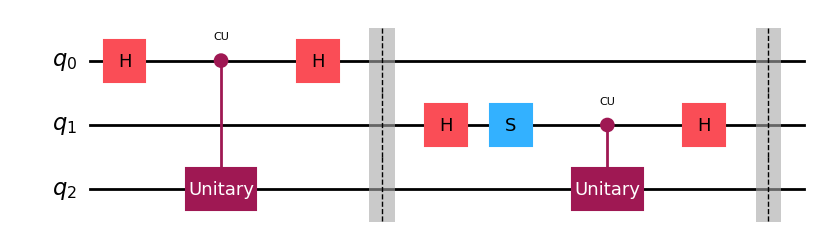

In [21]:
U = np.array([[1, 0],[0, np.exp(3*np.pi*1j*(1/3))]])
kqpe = KQPE(unitary=U, precision=16)
kq_circ = kqpe.get_circuit(show=True, save_circ=True,
                           circ_name="KQPE_circ_1qubit.JPG")

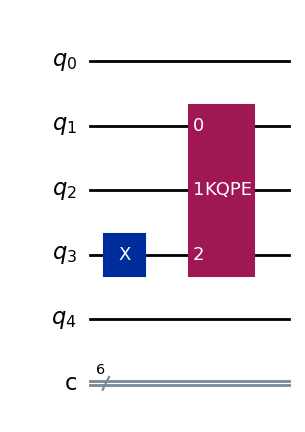

In [22]:
q = QuantumCircuit(5, 6)
q.x(3)
q.append(kq_circ, qargs=[1, 2, 3])
q.draw('mpl')

## Running the circuit

Shots: 655360


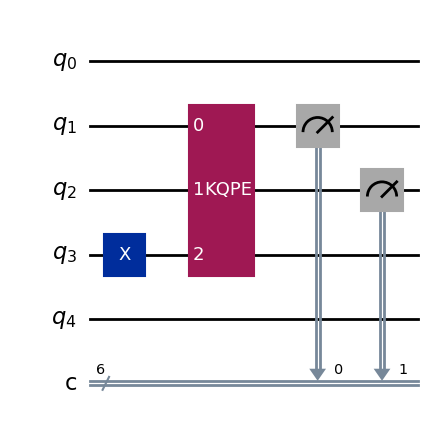

Measurement results: {'000001': 327762, '000011': 327598}


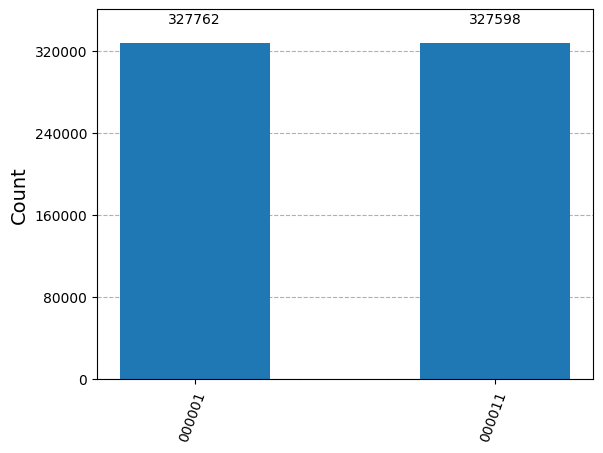

Time taken on Quantum Computer is : 3.990993022918701
Phase of the unitary is : (-0.4999601724088712, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [23]:
start = time.time()
phase = kqpe.get_phase(backend=backend, QC=q, ancilla=[1, 2], clbits=[0, 1], show=True)
end = time.time()
print("Time taken on Quantum Computer is :", end - start)
print("Phase of the unitary is :", phase)


###simulating a quantum computer's results

Shots: 655360


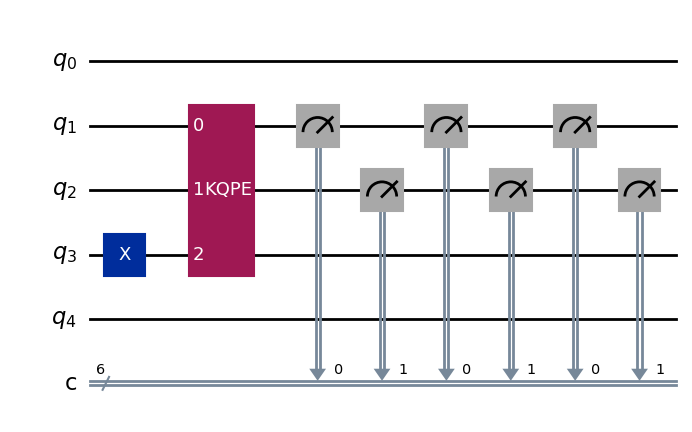

Measurement results: {'000000': 32868, '000010': 30595, '000011': 285649, '000001': 306248}


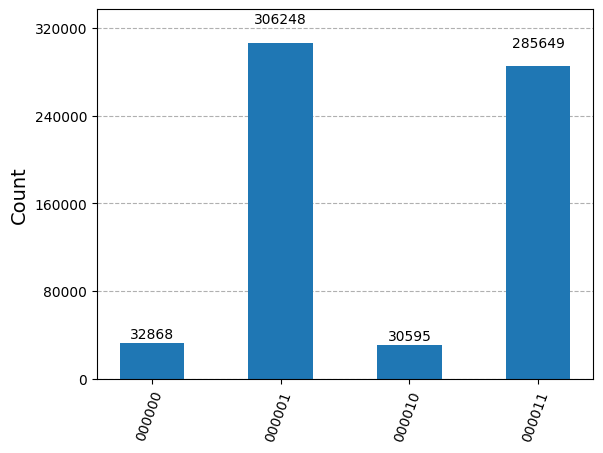

Time taken on Simulation Computer is : 2.8870842456817627
Phase of the unitary is : (-0.4931156563522285, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
                                     
q_0: ────────────────────────────────
          ┌───────┐┌─┐   ┌─┐   ┌─┐   
q_1: ─────┤0      ├┤M├───┤M├───┤M├───
          │       │└╥┘┌─┐└╥┘┌─┐└╥┘┌─┐
q_2: ─────┤1 KQPE ├─╫─┤M├─╫─┤M├─╫─┤M├
     ┌───┐│       │ ║ └╥┘ ║ └╥┘ ║ └╥┘
q_3: ┤ X ├┤2      ├─╫──╫──╫──╫──╫──╫─
     └───┘└───────┘ ║  ║  ║  ║  ║  ║ 
q_4: ───────────────╫──╫──╫──╫──╫──╫─
                    ║  ║  ║  ║  ║  ║ 
c: 6/═══════════════╩══╩══╩══╩══╩══╩═
                    0  1  0  1  0  1 


In [25]:

start = time.time()
phase = kqpe.get_phase(backend=FakeManilaV2(), QC=q, ancilla=[1, 2], clbits=[0, 1], show=True)
end = time.time()
print("Time taken on Simulation Computer is :", end - start)
print("Phase of the unitary is :", phase)
print(q)

### Testing Kitaev for 2-qubits
- Making a Controlled phase gate with phase as 1/7
- The eigenvector is $ |11\rangle$

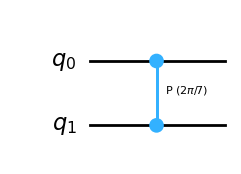

In [26]:
q = QuantumCircuit(2, name='Unitary')
q.cp(2*np.pi*(1/7), 0, 1)
q.draw('mpl')

In [27]:
unitary = q

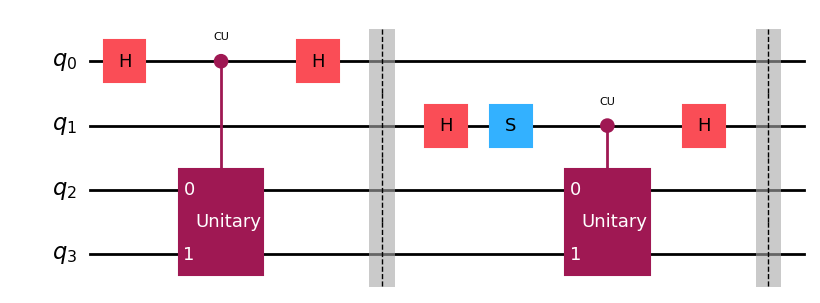

In [28]:
kqpe = KQPE(unitary, precision=12)
kq_circ = kqpe.get_circuit(show=True)

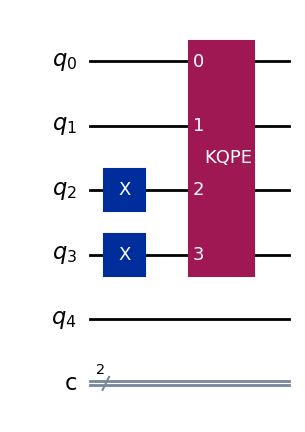

In [29]:
q = QuantumCircuit(5, 2)
q.x([2, 3])
q.append(kq_circ, qargs=[0, 1, 2, 3])
q.draw('mpl')

In [30]:
sim = Aer.get_backend('qasm_simulator')

Shots: 40960


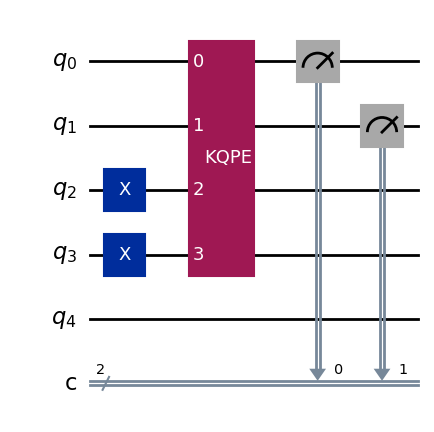

Measurement results: {'01': 862, '11': 6799, '10': 29674, '00': 3625}


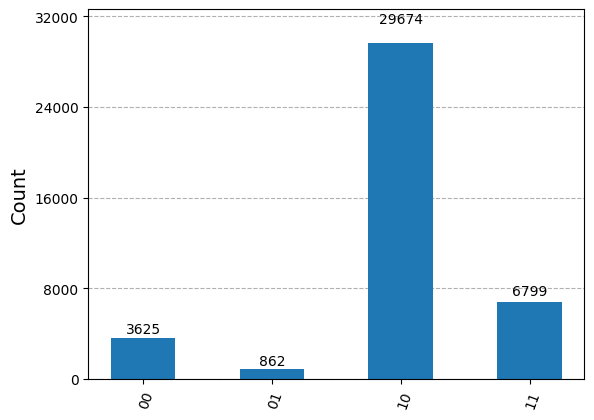

In [31]:
phase = kqpe.get_phase(backend=sim, QC=q, ancilla=[
                       0, 1], clbits=[0, 1], show=True)

In [46]:
print("Phase returned is :", phase)

Phase returned is : (0.14288165025700245, [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1])


- Let us plot a graph with the returned phase and see how close this estimate is to the actual eigenvalue of the matrix being measured

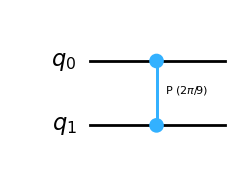

In [88]:
# select the amount of phase shift to be applied
PhaseShiftAmount = 1/9
q = QuantumCircuit(2, name='Phase Unitary')
q.cp(2*np.pi*(PhaseShiftAmount), 0, 1)
display(q.draw('mpl'))
unitary = q

In [79]:
precision = [i for i in range(8, 18)]
precision

[8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [89]:
estimates, errors = [], []
for prec in precision:
    kqpe = KQPE(unitary, precision=prec)
    kq_circ = kqpe.get_circuit(show=False)

    # making circuit
    q = QuantumCircuit(5, 2)
    q.x([2, 3])
    q.append(kq_circ, qargs=[0, 1, 2, 3])

    # getting the phase
    phase = kqpe.get_phase(backend=sim, QC=q, ancilla=[
                           0, 1], clbits=[0, 1], show=False)
    estimates.append(phase[0])
    errors.append(abs(PhaseShiftAmount - phase[0]))

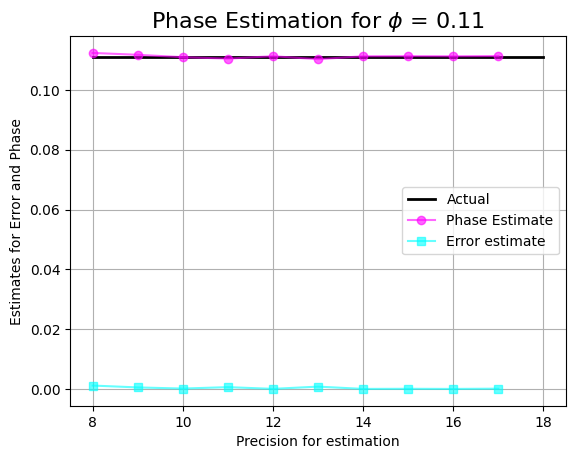

In [91]:
import matplotlib.pyplot as plt
plt.title(f"Phase Estimation for $\\phi$ = {PhaseShiftAmount:.2f}", fontsize=16)
plt.xlabel("Precision for estimation")
plt.ylabel("Estimates for Error and Phase")
plt.plot([8, 18], [PhaseShiftAmount, PhaseShiftAmount], color='black', label='Actual', linewidth=2)
plt.plot(precision, estimates, marker='o', color='magenta',
         alpha=0.6, label='Phase Estimate')
plt.plot(precision, errors, marker='s', color='cyan',
         alpha=0.6, label="Error estimate")
plt.grid()
plt.legend()
plt.savefig("Kitaev_Multiqubit_Estimation_Plot.JPG", dpi=200)

### Testing Kitaev's Algorithm for 1, 2, and 3 Qubits Across Varying Precision

In [ ]:
import time

In [ ]:
# Function to run phase estimation and measure time
def run_phase_estimation(unitary, num_qubits, precision, show=False):
    kqpe = KQPE(unitary=unitary, precision=precision)
    kq_circ = kqpe.get_circuit(show=show)

    # Create a QuantumCircuit with the required number of qubits
    total_qubits = num_qubits + 2  # 2 ancilla qubits
    qc = QuantumCircuit(total_qubits, 2)
    for i in range(num_qubits):
        qc.x(i + 2)  # Prepare eigenvector |11...1>

    qc.append(kq_circ, qargs=[i for i in range(total_qubits)])

    start_time = time.time()

    # Run the circuit on the qasm_simulator
    sim = Aer.get_backend('qasm_simulator')
    phase = kqpe.get_phase(backend=sim, QC=qc, ancilla=[0, 1], clbits=[0, 1], show=show)

    end_time = time.time()

    execution_time = end_time - start_time
    return phase, execution_time

#### Define the precision range for the estimation

In [ ]:
precision_range = [i for i in range(8, 18)]

In [ ]:
# Unitary matrices for 1, 2, and 3 qubits
U1 = np.array([[1, 0],
              [0, np.exp(2*np.pi*1j*(1/3))]])

U2 = QuantumCircuit(2, name='Unitary')
U2.cp(2*np.pi*(1/7), 0, 1)

U3 = QuantumCircuit(3, name='Unitary')
U3.cp(2*np.pi*(1/5), 0, 1)
U3.cp(2*np.pi*(1/5), 1, 2)

In [ ]:
# Storage for results
results = {
    "1_qubit": {"phases": [], "times": [], "errors": []},
    "2_qubit": {"phases": [], "times": [], "errors": []},
    "3_qubit": {"phases": [], "times": [], "errors": []},
}

In [ ]:
# Expected phases for comparison
expected_phases = {
    "1_qubit": 1/3,
    "2_qubit": 1/7,
    "3_qubit": 1/5,
}

#### Running phase estimation for varying precision

In [ ]:
for precision in precision_range:
    print(f"Running phase estimation for precision {precision}...")

    # For 1 qubit
    phase_1q, time_1q = run_phase_estimation(U1, 1, precision, show=False)
    results["1_qubit"]["phases"].append(phase_1q[0])
    results["1_qubit"]["times"].append(time_1q)
    results["1_qubit"]["errors"].append(abs(expected_phases["1_qubit"] - phase_1q[0]))

    # For 2 qubits
    phase_2q, time_2q = run_phase_estimation(U2, 2, precision, show=False)
    results["2_qubit"]["phases"].append(phase_2q[0])
    results["2_qubit"]["times"].append(time_2q)
    results["2_qubit"]["errors"].append(abs(expected_phases["2_qubit"] - phase_2q[0]))

    # For 3 qubits
    phase_3q, time_3q = run_phase_estimation(U3, 3, precision, show=False)
    results["3_qubit"]["phases"].append(phase_3q[0])
    results["3_qubit"]["times"].append(time_3q)
    results["3_qubit"]["errors"].append(abs(expected_phases["3_qubit"] - phase_3q[0]))


Running phase estimation for precision 8...
Running phase estimation for precision 9...
Running phase estimation for precision 10...
Running phase estimation for precision 11...
Running phase estimation for precision 12...
Running phase estimation for precision 13...
Running phase estimation for precision 14...
Running phase estimation for precision 15...
Running phase estimation for precision 16...
Running phase estimation for precision 17...


#### Print a summary of the results

In [ ]:
print("Precision | 1 Qubit Time | 2 Qubits Time | 3 Qubits Time")
for i, precision in enumerate(precision_range):
    print(f"{precision:9} | {results['1_qubit']['times'][i]:14.6f} | {results['2_qubit']['times'][i]:14.6f} | {results['3_qubit']['times'][i]:14.6f}")

Precision | 1 Qubit Time | 2 Qubits Time | 3 Qubits Time
        8 |       0.335072 |       0.576678 |       0.571399
        9 |       0.209980 |       0.234018 |       0.171492
       10 |       0.207795 |       0.252950 |       0.226190
       11 |       0.417816 |       0.524980 |       0.302445
       12 |       0.316302 |       0.326592 |       0.338133
       13 |       0.347775 |       0.357338 |       0.547759
       14 |       0.615403 |       0.687489 |       0.735981
       15 |       0.550337 |       0.530543 |       0.568677
       16 |       1.068173 |       1.719506 |       1.405340
       17 |       1.918031 |       1.887502 |       2.000565


#### Plotting the Speedup and Accuracy

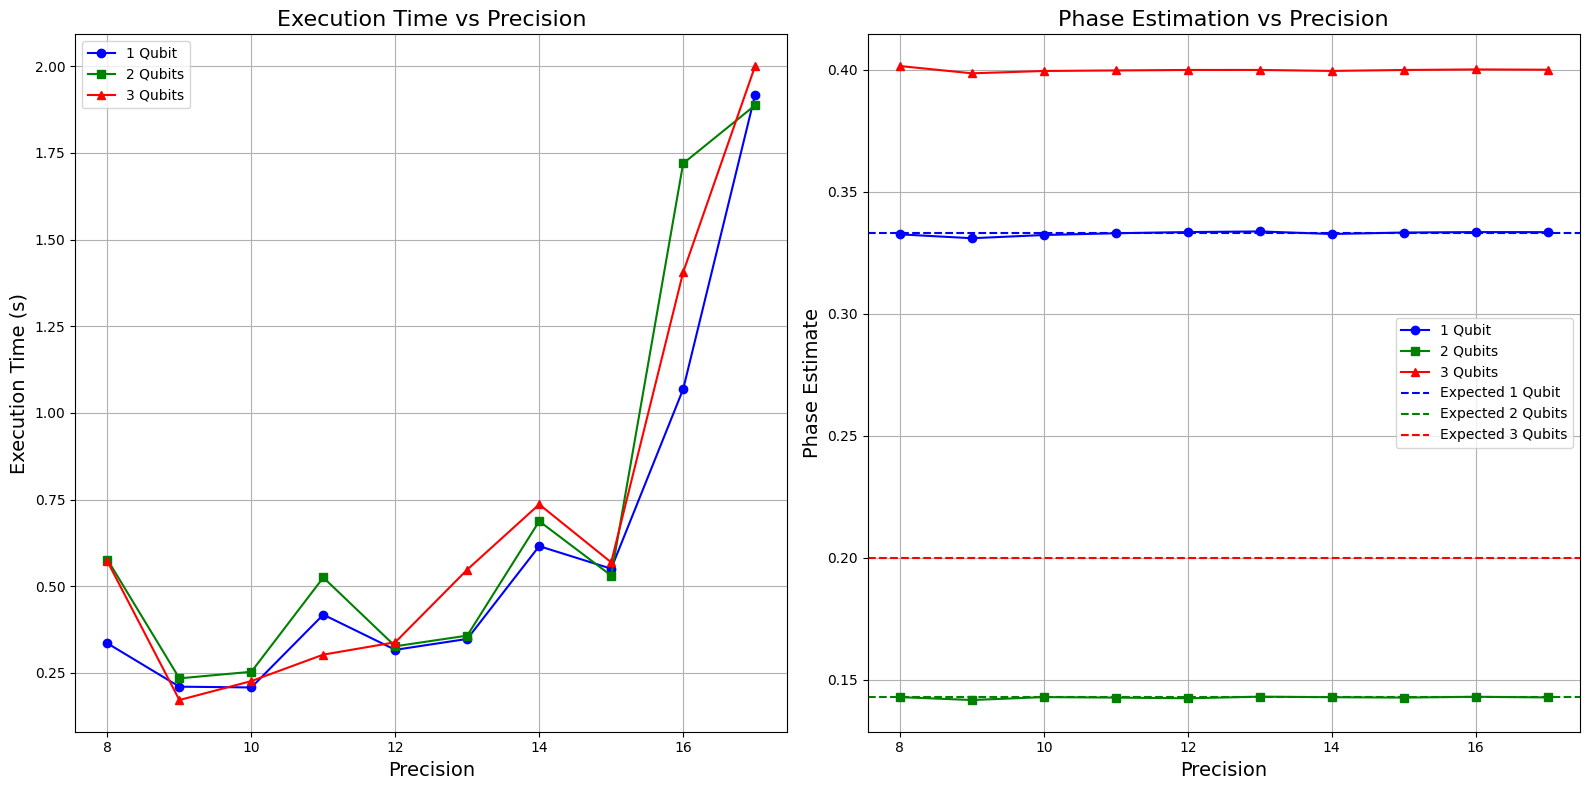

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))

# Plot execution time for different qubit setups
plt.subplot(1, 2, 1)
plt.title("Execution Time vs Precision", fontsize=16)
plt.xlabel("Precision", fontsize=14)
plt.ylabel("Execution Time (s)", fontsize=14)
plt.plot(precision_range, results["1_qubit"]["times"], marker='o', color='blue', label='1 Qubit')
plt.plot(precision_range, results["2_qubit"]["times"], marker='s', color='green', label='2 Qubits')
plt.plot(precision_range, results["3_qubit"]["times"], marker='^', color='red', label='3 Qubits')
plt.grid(True)
plt.legend()

# Plot phase estimation accuracy for different qubit setups
plt.subplot(1, 2, 2)
plt.title("Phase Estimation vs Precision", fontsize=16)
plt.xlabel("Precision", fontsize=14)
plt.ylabel("Phase Estimate", fontsize=14)
plt.plot(precision_range, results["1_qubit"]["phases"], marker='o', color='blue', label='1 Qubit')
plt.plot(precision_range, results["2_qubit"]["phases"], marker='s', color='green', label='2 Qubits')
plt.plot(precision_range, results["3_qubit"]["phases"], marker='^', color='red', label='3 Qubits')
plt.axhline(y=expected_phases["1_qubit"], color='blue', linestyle='--', label='Expected 1 Qubit')
plt.axhline(y=expected_phases["2_qubit"], color='green', linestyle='--', label='Expected 2 Qubits')
plt.axhline(y=expected_phases["3_qubit"], color='red', linestyle='--', label='Expected 3 Qubits')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig("Kitaev_Qubit_Speedup_Accuracy_Varying_Precision.JPG", dpi=200)
plt.show()

#### Plotting the errors

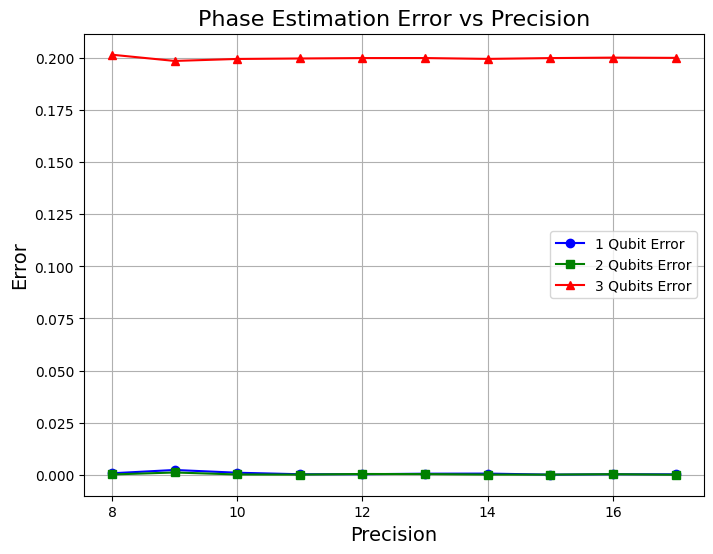

In [ ]:
plt.figure(figsize=(8, 6))
plt.title("Phase Estimation Error vs Precision", fontsize=16)
plt.xlabel("Precision", fontsize=14)
plt.ylabel("Error", fontsize=14)
plt.plot(precision_range, results["1_qubit"]["errors"], marker='o', color='blue', label='1 Qubit Error')
plt.plot(precision_range, results["2_qubit"]["errors"], marker='s', color='green', label='2 Qubits Error')
plt.plot(precision_range, results["3_qubit"]["errors"], marker='^', color='red', label='3 Qubits Error')
plt.grid(True)
plt.legend()

plt.savefig("Kitaev_Qubit_Error_Varying_Precision.JPG", dpi=200)
plt.show()